### 1. <a id='importation'>Détail des données fournies</a>

In [206]:
import warnings

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from lazypredict.Supervised import LazyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# Ignorer les avertissements
warnings.filterwarnings('ignore')
path = "../data/"

DELIMITER = "--------------------------------"

---

### 2. <a id='chargement'>Chargement et initialisation des données</a>

In [207]:
#On vient charger les différents dataset
employee_df = pd.read_csv(path + "employee_survey_data.csv")
general_df = pd.read_csv(path + "general_data.csv")
manager_df = pd.read_csv(path + "manager_survey_data.csv")
in_time_df = pd.read_csv(path + "in_time.csv")
out_time_df = pd.read_csv(path + "out_time.csv")

dataframes = [
    ("employee_df", employee_df),
    ("general_df", general_df),
    ("manager_df", manager_df),
    ("in_time_df", in_time_df),
    ("out_time_df", out_time_df)
]

for name, df in dataframes:
    print(DELIMITER)
    print(f"Nom du DataFrame : {name}")
    print(f"Description : {df.describe()}")
    print(f"Valeurs nulles : ")
    print(f"{df.isnull().sum()}")


--------------------------------
Nom du DataFrame : employee_df
Description :        EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count   4410.0000                4385.0000        4390.0000        4372.0000
mean    2205.5000                   2.7236           2.7282           2.7614
std     1273.2017                   1.0928           1.1013           0.7062
min        1.0000                   1.0000           1.0000           1.0000
25%     1103.2500                   2.0000           2.0000           2.0000
50%     2205.5000                   3.0000           3.0000           3.0000
75%     3307.7500                   4.0000           4.0000           3.0000
max     4410.0000                   4.0000           4.0000           4.0000
Valeurs nulles : 
EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64
--------------------------------
Nom du DataFrame : general_df
Description :  

---

Résumé des différentes données présentes dans les dataset:

**Dataset employee_survey_data**
| #  | Colonne                   | Type      | Description                                    | Valeurs manquantes | Moyenne | Médiane | Min | Max |
|----|---------------------------|-----------|-----------------------------------------------|--------------------|---------|---------|-----|-----|
| 1  | EmployeeID                | int64     | Identifiant unique pour chaque employé       | 0                  | -       | -       | -   | -   |
| 2  | EnvironmentSatisfaction   | float64   | Satisfaction par rapport à l’environnement   | 25                 | 2.72    | 3       | 1   | 4   |
| 3  | JobSatisfaction           | float64   | Satisfaction au travail                      | 20                 | 2.73    | 3       | 1   | 4   |
| 4  | WorkLifeBalance           | float64   | Équilibre vie pro/perso                      | 38                 | 2.76    | 3       | 1   | 4   |

**Dataset general_data**
| #  | Colonne                     | Type      | Description                                    | Valeurs manquantes | Moyenne   | Médiane | Min | Max      |
|----|-----------------------------|-----------|-----------------------------------------------|--------------------|-----------|---------|-----|----------|
| 1  | Age                         | int64     | Âge des employés                              | 0                  | 36.92     | 36      | 18  | 60       |
| 2  | Attrition                   | object    | Indique si l'employé a quitté l'entreprise    | 0                  | -         | -       | -   | -        |
| 3  | BusinessTravel              | object    | Fréquence des déplacements professionnels     | 0                  | -         | -       | -   | -        |
| 4  | Department                  | object    | Département auquel l'employé appartient       | 0                  | -         | -       | -   | -        |
| 5  | DistanceFromHome            | int64     | Distance entre domicile et lieu de travail    | 0                  | 9.19      | 7       | 1   | 29       |
| 6  | Education                   | int64     | Niveau d'éducation (1 à 5)                    | 0                  | 2.91      | 3       | 1   | 5        |
| 7  | EducationField              | object    | Domaine d'étude                               | 0                  | -         | -       | -   | -        |
| 8  | EmployeeCount               | int64     | Toujours égal à 1                             | 0                  | 1.0       | 1       | 1   | 1        |
| 9  | EmployeeID                  | int64     | Identifiant unique pour chaque employé        | 0                  | -         | -       | 1   | 4410     |
| 10 | Gender                      | object    | Genre de l'employé                            | 0                  | -         | -       | -   | -        |
| 11 | JobLevel                    | int64     | Niveau de poste (1 à 5)                       | 0                  | 2.06      | 2       | 1   | 5        |
| 12 | JobRole                     | object    | Intitulé du poste                             | 0                  | -         | -       | -   | -        |
| 13 | MaritalStatus               | object    | État civil                                    | 0                  | -         | -       | -   | -        |
| 14 | MonthlyIncome               | int64     | Revenu mensuel (en dollars)                  | 0                  | 65,029    | 49,190  | 10,090 | 199,990 |
| 15 | NumCompaniesWorked          | float64   | Nombre d'entreprises où l'employé a travaillé| 19                 | 2.69      | 2       | 0   | 9        |
| 16 | Over18                      | object    | Toujours "Y"                                | 0                  | -         | -       | -   | -        |
| 17 | PercentSalaryHike           | int64     | Augmentation de salaire en %                  | 0                  | 15.21     | 14      | 11  | 25       |
| 18 | StandardHours               | int64     | Toujours égal à 8                             | 0                  | 8.0       | 8       | 8   | 8        |
| 19 | StockOptionLevel            | int64     | Niveau d'options sur actions (0 à 3)         | 0                  | 0.79      | 1       | 0   | 3        |
| 20 | TotalWorkingYears           | float64   | Années totales d'expérience                  | 9                  | 11.28     | 10      | 0   | 40       |
| 21 | TrainingTimesLastYear       | int64     | Nombre de formations l'année précédente       | 0                  | 2.80      | 3       | 0   | 6        |
| 22 | YearsAtCompany              | int64     | Années passées dans l'entreprise              | 0                  | 7.01      | 5       | 0   | 40       |
| 23 | YearsSinceLastPromotion     | int64     | Années depuis la dernière promotion           | 0                  | 2.19      | 1       | 0   | 15       |
| 24 | YearsWithCurrManager        | int64     | Années passées avec le manager actuel         | 0                  | 4.12      | 3       | 0   | 17       |


**Dataset manager_survey_data**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes | Moyenne | Médiane | Min | Max | Distribution attendue |
|----|----------------------|---------|-------------------------------------------|--------------------|---------|---------|-----|-----|----------------------|
| 1  | EmployeeID          | int64   | Identifiant unique pour chaque employé   | 0                  | -       | -       | -   | -   | Unique, sans répétition |
| 2  | JobInvolvement      | int64   | Implication dans le travail (1 à 4)      | 0                  | 2.73    | 3       | 1   | 4   | Répartition probable autour de 3 |
| 3  | PerformanceRating   | int64   | Évaluation de la performance (3 à 4)     | 0                  | 3.15    | 3       | 3   | 4   | Très concentré sur 3 et 4 |


**Dataset in_time**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date d'arrivée      | 4410                  |
| 3  | 2015-01-02   | object   | Date d'arrivée     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

**Dataset out_time**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date de départ      | 4410                  |
| 3  | 2015-01-02   | object   | Date de départ     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

---


### 3. <a id='merge'>Pré-traitements spécifique</a>

Notre objectif est de venir merger ces différents dataset afin de travailler avec un seul DataFrame.
En observant les différentes caractéristiques des dataset, on s'est aperçu qu'on peut dès à présent fusionner tous les dataset sauf "in_time" et "out_time" car les informations présentes sont très différentes des autres dataset, sur la forme ou le fond.
On va donc venir synthétiser ces données afin de récupérer l'heure totale de travail pour chaque employé.


In [208]:
in_time_df = in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})
out_time_df = out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})

### Vérifications concernant les 2 dataset :

# Valeurs des EmployeeID
if not in_time_df['EmployeeID'].equals(out_time_df['EmployeeID']):
    print("Les EmployeeID ne correspondent pas entre les dataset : in_time_df et out_time_df")

# Correspondance des valeurs NA
in_time_na = in_time_df.isna()
out_time_na = out_time_df.isna()
if not in_time_na.equals(out_time_na):
    print("Les valeurs NA dans in_time_df et out_time_df ne correspondent pas")

### On est maintenant sûr que les dataset sont conformes et peuvent donc être fusionnés, on va venir convertir les objets en date afin de récuperer les heures totales.

for col in in_time_df.columns[1:]:
    in_time_df[col] = pd.to_datetime(in_time_df[col], errors='coerce')
    out_time_df[col] = pd.to_datetime(out_time_df[col], errors='coerce')

time_difference = out_time_df.iloc[:, 1:] - in_time_df.iloc[:, 1:]

time_difference_in_hours = time_difference.apply(lambda row: row.dt.total_seconds() / 3600, axis=1)
total_hours_per_employee = time_difference_in_hours.sum(axis=1, skipna=True).round(2)

out_time_df["Total_Hours"] = total_hours_per_employee
total_hours_df = out_time_df[["EmployeeID", "Total_Hours"]]
total_hours_df

,EmployeeID,Total_Hours
0,1,1710.6900
1,2,1821.6800
2,3,1697.2000
3,4,1690.5100
4,5,1961.5100
...,...,...
4405,4406,2070.9100
4406,4407,1468.4000
4407,4408,1780.2300
4408,4409,2287.7200


### 3. <a id='merge'>Merge et sauvegarde des datasets</a>

In [209]:
company_df = general_df.merge(employee_df, on='EmployeeID').merge(manager_df, on='EmployeeID').merge(total_hours_df,
                                                                                                     on='EmployeeID')
company_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0000,4.0000,2.0000,3,3,1710.6900
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0000,2.0000,4.0000,2,4,1821.6800
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0000,2.0000,1.0000,3,3,1697.2000
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0000,4.0000,3.0000,2,3,1690.5100
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0000,1.0000,3.0000,3,3,1961.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,5,3,0,2,4.0000,1.0000,3.0000,3,3,2070.9100
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,2,3,0,2,4.0000,4.0000,3.0000,2,3,1468.4000
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,4,1,2,1.0000,3.0000,3.0000,3,4,1780.2300
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,2,9,7,8,4.0000,1.0000,3.0000,2,3,2287.7200


---

### 4. <a id='apercu'>Aperçu général</a>

In [210]:
print(f"Nombre de lignes : {company_df.shape[0]}")
print(f"Nombre de colonnes : {company_df.shape[1]}")

Nombre de lignes : 4410
Nombre de colonnes : 30


In [211]:
print("Informations de base :")
company_df.info()

Informations de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  N

In [212]:
print(f"Sommaire des statistiques : \n{company_df.describe()}")

Sommaire des statistiques : 
            Age  DistanceFromHome  Education  EmployeeCount  EmployeeID  \
count 4410.0000         4410.0000  4410.0000      4410.0000   4410.0000   
mean    36.9238            9.1925     2.9129         1.0000   2205.5000   
std      9.1333            8.1050     1.0239         0.0000   1273.2017   
min     18.0000            1.0000     1.0000         1.0000      1.0000   
25%     30.0000            2.0000     2.0000         1.0000   1103.2500   
50%     36.0000            7.0000     3.0000         1.0000   2205.5000   
75%     43.0000           14.0000     4.0000         1.0000   3307.7500   
max     60.0000           29.0000     5.0000         1.0000   4410.0000   

       JobLevel  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count 4410.0000      4410.0000           4391.0000          4410.0000   
mean     2.0639     65029.3129              2.6948            15.2095   
std      1.1067     47068.8886              2.4989             3.6591   
min

In [213]:
print("Nombre de valeurs uniques par colonne :")
for column in company_df.columns:
    print(f"- {column} : {company_df[column].nunique()} valeurs uniques")

Nombre de valeurs uniques par colonne :
- Age : 43 valeurs uniques
- Attrition : 2 valeurs uniques
- BusinessTravel : 3 valeurs uniques
- Department : 3 valeurs uniques
- DistanceFromHome : 29 valeurs uniques
- Education : 5 valeurs uniques
- EducationField : 6 valeurs uniques
- EmployeeCount : 1 valeurs uniques
- EmployeeID : 4410 valeurs uniques
- Gender : 2 valeurs uniques
- JobLevel : 5 valeurs uniques
- JobRole : 9 valeurs uniques
- MaritalStatus : 3 valeurs uniques
- MonthlyIncome : 1349 valeurs uniques
- NumCompaniesWorked : 10 valeurs uniques
- Over18 : 1 valeurs uniques
- PercentSalaryHike : 15 valeurs uniques
- StandardHours : 1 valeurs uniques
- StockOptionLevel : 4 valeurs uniques
- TotalWorkingYears : 40 valeurs uniques
- TrainingTimesLastYear : 7 valeurs uniques
- YearsAtCompany : 37 valeurs uniques
- YearsSinceLastPromotion : 16 valeurs uniques
- YearsWithCurrManager : 18 valeurs uniques
- EnvironmentSatisfaction : 4 valeurs uniques
- JobSatisfaction : 4 valeurs uniques


In [214]:
display(company_df.head())

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0000,4.0000,2.0000,3,3,1710.6900
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0000,2.0000,4.0000,2,4,1821.6800
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0000,2.0000,1.0000,3,3,1697.2000
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0000,4.0000,3.0000,2,3,1690.5100
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0000,1.0000,3.0000,3,3,1961.5100


---

### 5. <a id='missing-check'>Gestion des valeurs manquantes</a>

Valeurs manquantes par colonne :
NumCompaniesWorked         19
TotalWorkingYears           9
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64


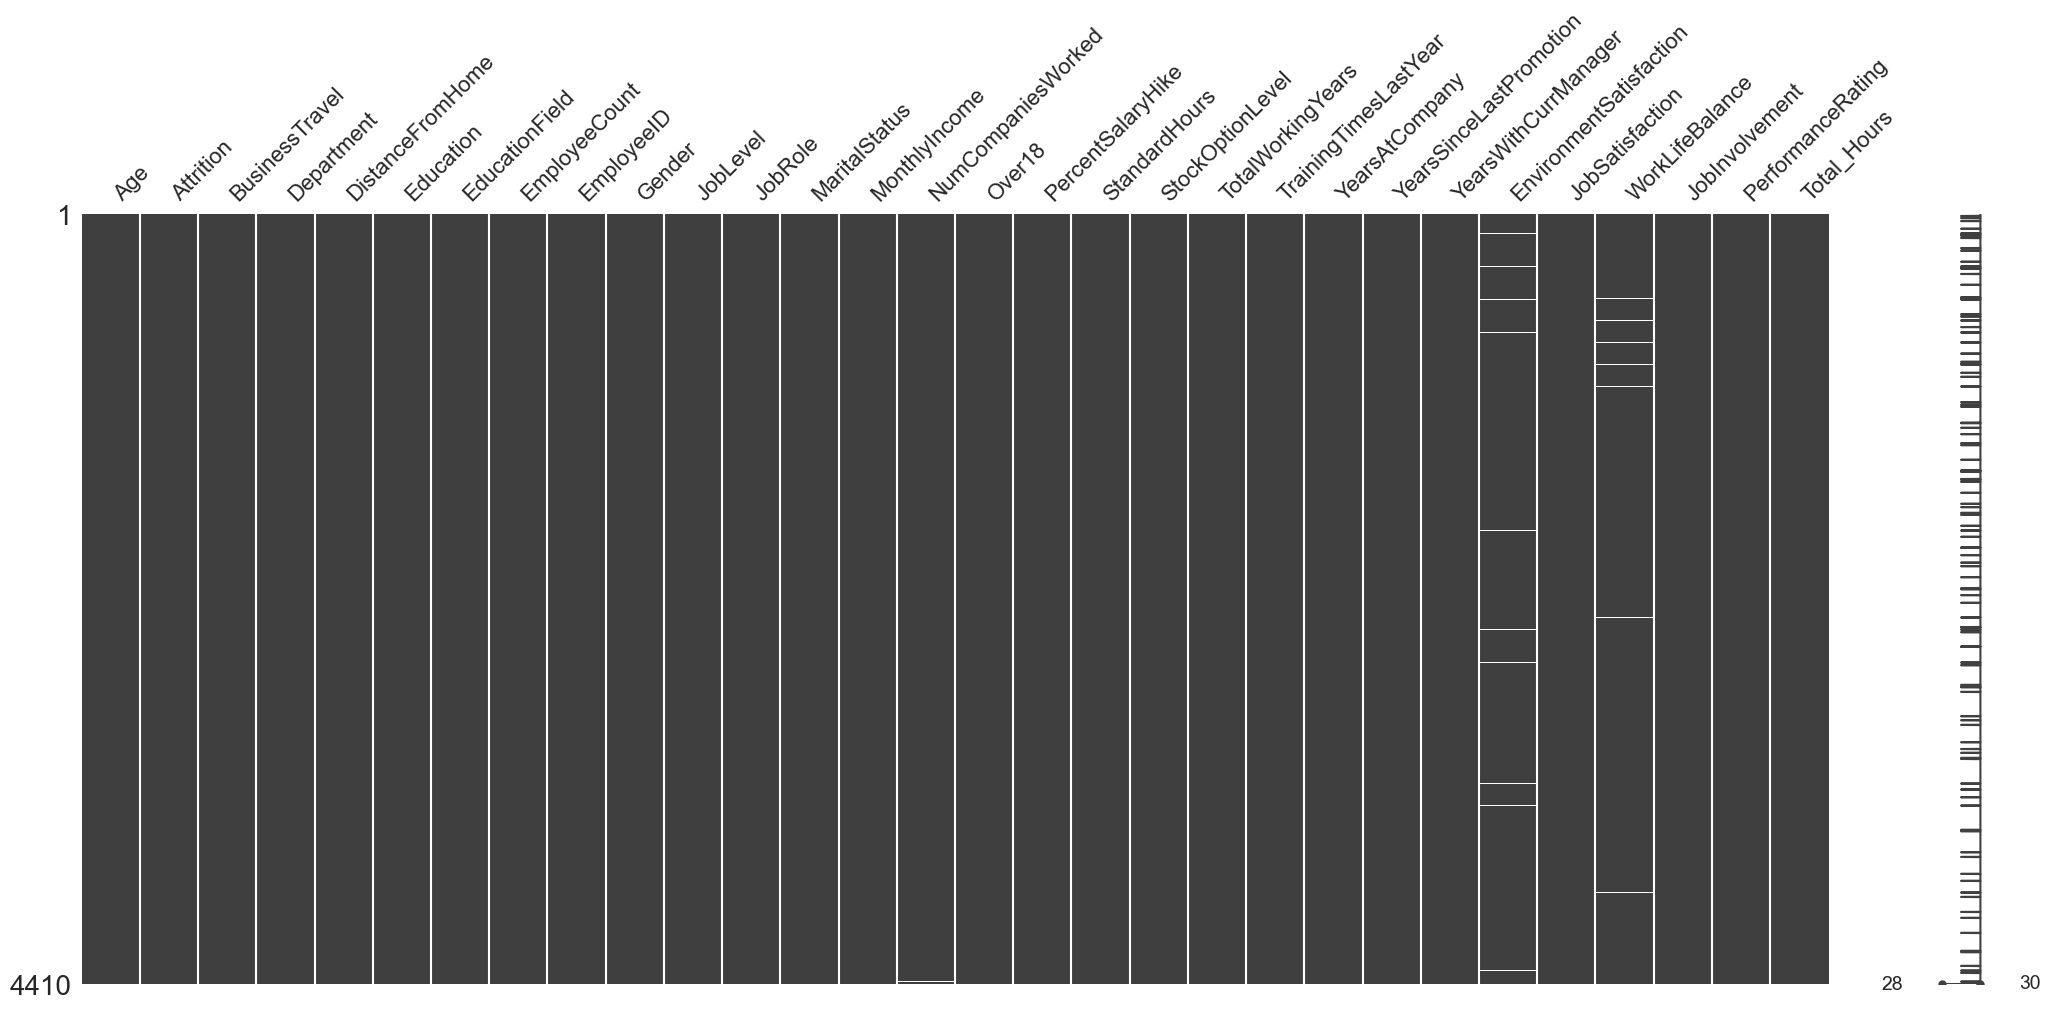

In [215]:
def check_missing_values(df):
    if (df.isnull().sum() > 0).any():
        missing_values = df.isnull().sum()[df.isnull().sum() > 0]
        print("Valeurs manquantes par colonne :")
        print(missing_values)
    else:
        print("Il n'y a pas de valeurs manquantes dans le dataset")
    msno.matrix(df)
    plt.show()


check_missing_values(company_df)

---

### 6. <a id='doublons'>Gestion des valeurs dupliquées</a>

In [216]:
def check_duplicates(df):
    if df.duplicated().sum() > 0:
        print(f"Nombre de valeurs dupliquées : {df.duplicated().sum()}")
        merged_dataset = df.drop_duplicates()
        print(f"Nombre de lignes après suppression des doublons : {merged_dataset.shape[0]}")
    else:
        print("Il n'y a pas de valeurs dupliquées dans le dataset")


check_duplicates(company_df)

Il n'y a pas de valeurs dupliquées dans le dataset


---

### 7. <a id='types'>Vérification des types de données</a>

In [217]:
#Valeurs numériques
numerical_columns = company_df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns)

#Valeurs non numériques
categorical_columns = company_df.select_dtypes(include=['object']).columns
print(categorical_columns)

print(f"Nombre de colonnes traitées : {len(numerical_columns) + len(categorical_columns)}")
print(f"Nombre de colonnes dans le dataset : {company_df.shape[1]}")


Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating',
       'Total_Hours'],
      dtype='object')
Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')
Nombre de colonnes traitées : 30
Nombre de colonnes dans le dataset : 30


---

### 8. <a id='pipeline'>Pipeline de traitement des données</a>

In [218]:
num_features = numerical_columns.tolist()
cat_features = categorical_columns.tolist()

# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline spécifique pour la colonne Attrition
attrition_pipeline = Pipeline([
    ('bool_transform', FunctionTransformer(lambda x: x == 'Yes', validate=False))
])

# Pipeline de preprocessing
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, [col for col in cat_features if col != 'Attrition']),
    ('cat_specific', attrition_pipeline, ['Attrition'])
])

# Appliquer la transformation sur les données d'origine
company_transformed_df = preprocessor.fit_transform(company_df)

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_one_hot_columns = cat_encoder.get_feature_names_out([col for col in cat_features if col != 'Attrition']).tolist()

# Ajouter la colonne `Attrition` traitée
final_columns = num_features + cat_one_hot_columns + ['Attrition']

# Créer le DataFrame transformé
processed_df = pd.DataFrame(company_transformed_df, columns=final_columns)

# Afficher les premières lignes du DataFrame transformé
processed_df.head()


,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,Attrition
0,51.0000,6.0000,2.0000,1.0000,1.0000,1.0000,131160.0000,1.0000,11.0000,8.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
1,31.0000,10.0000,1.0000,1.0000,2.0000,1.0000,41890.0000,0.0000,23.0000,8.0000,...,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,1.0000
2,32.0000,17.0000,4.0000,1.0000,3.0000,4.0000,193280.0000,1.0000,15.0000,8.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
3,38.0000,2.0000,5.0000,1.0000,4.0000,3.0000,83210.0000,3.0000,11.0000,8.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
4,32.0000,10.0000,1.0000,1.0000,5.0000,1.0000,23420.0000,4.0000,12.0000,8.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000


On vient vérifier qu'il n'y a plus de valeurs manquantes dans le dataset :

Il n'y a pas de valeurs manquantes dans le dataset


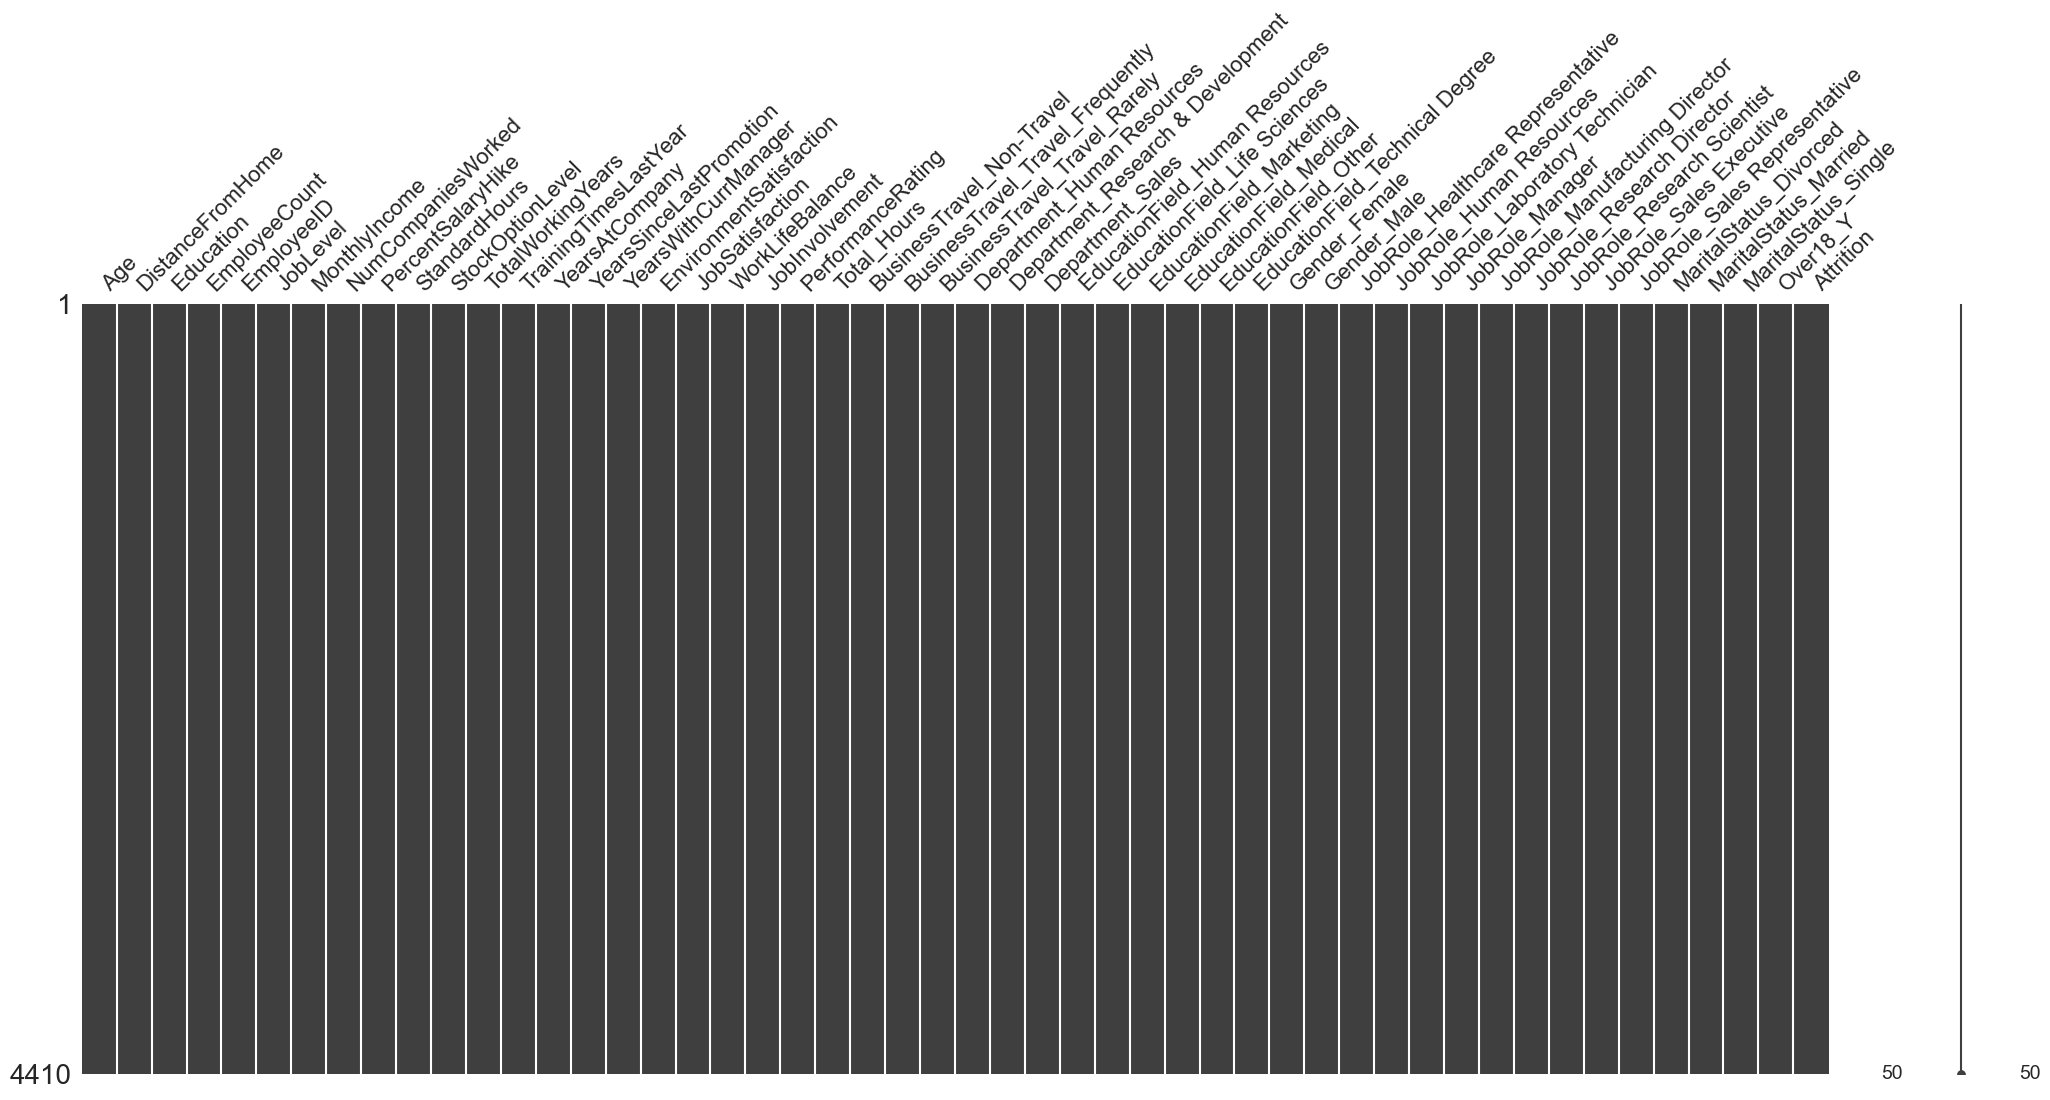

In [219]:
check_missing_values(processed_df)

**EDA** A présent, on va venir réaliser une analyse exploratoire des données pour mieux comprendre les différentes variables et leur impact sur l'attrition des employés.

In [220]:
# On vient récupérer les coefficients de corrélation de Pearson entre les différentes variables (relation linéaire)
correlation_matrix = processed_df.corr()
correlation_with_attrition = correlation_matrix['Attrition'].sort_values(ascending=False)

# Valeurs de corrélation avec la variable cible
print(correlation_with_attrition)

Attrition                            1.0000
Total_Hours                          0.1989
MaritalStatus_Single                 0.1754
BusinessTravel_Travel_Frequently     0.1151
EducationField_Human Resources       0.0916
Department_Human Resources           0.0808
JobRole_Research Director            0.0498
NumCompaniesWorked                   0.0421
PercentSalaryHike                    0.0325
JobRole_Research Scientist           0.0275
PerformanceRating                    0.0234
Gender_Male                          0.0181
EducationField_Life Sciences         0.0124
JobRole_Sales Executive              0.0109
JobRole_Laboratory Technician        0.0012
EducationField_Medical               0.0008
EducationField_Marketing            -0.0038
EmployeeID                          -0.0047
StockOptionLevel                    -0.0068
DistanceFromHome                    -0.0097
JobLevel                            -0.0103
JobRole_Sales Representative        -0.0111
JobRole_Healthcare Representativ

On remarque que pour une approche linéaire, les variables les plus corrélées avec l'attrition sont : Total_Hours, MaritalStatus_Single, BusinessTravel_Travel_Frequently, EducationField_Human Resources, Department_Human Resources, JobRole_Research Director et NumCompaniesWorked


Cependant, il faut faire attention car il s'agit seulement des relations linéaires, il est possible que d'autres variables aient un impact sur l'attrition des employés.

In [221]:
# On sépare les données en train et test
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in split.split(processed_df, processed_df['Attrition']):
    strat_train_set = processed_df.loc[train_index]
    strat_test_set = processed_df.loc[test_index]

# On a donc nos variables data_train_set et data_test_set pour le train et le test
data_train_set = strat_train_set.copy()
data_test_set = strat_test_set.copy()

data = data_train_set
data_labels = strat_train_set["Attrition"].copy()
data_train_set = data.drop(['Attrition'], axis=1)


### 7. <a id='doublons'>Ajout et choix des modèles</a>

Afin d'obtenir un résultat précis, on vient utiliser la classe StratifiedShuffleSplit pour obtenir des splits stratifiés. On va ensuite entraîner différents modèles de classification pour prédire l'attrition des employés.

In [227]:
def evaluate_model(model_chose, n_split):
    model_name = model_chose.__class__.__name__
    print(f"Évaluation du modèle : {model_name}")
    # StratifiedShuffleSplit pour 5 splits
    stratified_split = StratifiedShuffleSplit(n_splits=n_split, test_size=0.2, random_state=42)

    accuracies = []

    for train_index, test_index in stratified_split.split(processed_df, processed_df['Attrition']):
        strat_train_set = processed_df.loc[train_index]
        strat_test_set = processed_df.loc[test_index]

        # Préparation des données d'entraînement et des labels
        data_train_set = strat_train_set.drop(['Attrition'], axis=1)
        data_labels = strat_train_set['Attrition'].copy()

        # Entraînement du modèle
        model_chose.fit(data_train_set, data_labels)
        # Prédictions
        y_pred = model_chose.predict(strat_test_set.drop(['Attrition'], axis=1))

        # Évaluation des performances pour ce split
        accuracy = accuracy_score(strat_test_set['Attrition'], y_pred)
        accuracies.append(accuracy)

    print(f"Précision sur les {n_split} splits : {accuracies}")
    print(f"Précision moyenne sur les {n_split} splits : {np.mean(accuracies):.4f}")

In [228]:
# Initialisation du modèle
extra_tree_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
evaluate_model(extra_tree_model, 5)

Évaluation du modèle : ExtraTreesClassifier
Précision sur les 5 splits : [0.9965986394557823, 0.9863945578231292, 0.9965986394557823, 0.9931972789115646, 0.9931972789115646]
Précision moyenne sur les 5 splits : 0.9932


In [229]:
logistic_model = LogisticRegression(random_state=42)
evaluate_model(logistic_model, 5)


Évaluation du modèle : LogisticRegression
Précision sur les 5 splits : [0.844671201814059, 0.8390022675736961, 0.8412698412698413, 0.844671201814059, 0.8503401360544217]
Précision moyenne sur les 5 splits : 0.8440


In [225]:
# Modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, 5)

Précision sur les 5 splits : [0.9886621315192744, 0.9739229024943311, 0.9886621315192744, 0.9897959183673469, 0.9920634920634921]
Précision moyenne sur les 5 splits : 0.9866


Pour avoir une autre idée, on peut utiliser la librairie Lazypredict qui permet de comparer rapidement les performances de plusieurs modèles de classification.

In [226]:
X = processed_df.drop('Attrition', axis=1)  # Les caractéristiques (features)
y = processed_df['Attrition']  # La variable cible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models


100%|██████████| 32/32 [00:05<00:00,  6.19it/s]

[LightGBM] [Info] Number of positive: 570, number of negative: 2958
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161565 -> initscore=-1.646632
[LightGBM] [Info] Start training from score -1.646632


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.9966,0.9894,0.9894,0.9966,0.4467
LabelSpreading,0.9921,0.9838,0.9838,0.9921,1.5004
LabelPropagation,0.9921,0.9838,0.9838,0.9921,1.0308
ExtraTreeClassifier,0.9853,0.9769,0.9769,0.9853,0.0205
LGBMClassifier,0.9841,0.9647,0.9647,0.9840,0.1029
RandomForestClassifier,0.9875,0.9610,0.9610,0.9873,0.5236
DecisionTreeClassifier,0.9660,0.9396,0.9396,0.9661,0.0534
BaggingClassifier,0.9671,0.9086,0.9086,0.9660,0.2769
SVC,0.9320,0.7930,0.7930,0.9248,0.2981
